# 3. Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Loan_data_7_v2.csv")

In [3]:
df.shape

(39786, 29)

In [4]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'annual_inc_cat_10',
       'target', 'loan_amnt_cat_10', 'inc_ver_status', 'inc_source_ver_status',
       'fico_range_low_cat_num', 'earliest_cr_line_year',
       'earliest_cr_line_month', 'issue_d_year', 'issue_d_month', 'grade_num',
       'home_MORTGAGE', 'home_OTHER', 'home_OWN', 'home_RENT'],
      dtype='object')

### Outliers

In [5]:
# wybieram kolumny, z których usunę wartości odstające
column_list_outliers = df.columns.tolist()
for column in column_list_outliers:
    print(f'Number of outliers in {column}: ',
          df.loc[(((df[column] - df[column].mean()) / df[column].std()).abs() > 3)][column].count())

Number of outliers in loan_amnt:  719
Number of outliers in term:  0
Number of outliers in int_rate:  38
Number of outliers in installment:  328
Number of outliers in emp_length:  0
Number of outliers in annual_inc:  289
Number of outliers in dti:  0
Number of outliers in delinq_2yrs:  1011
Number of outliers in fico_range_low:  3
Number of outliers in inq_last_6mths:  260
Number of outliers in open_acc:  373
Number of outliers in revol_bal:  872
Number of outliers in revol_util:  54
Number of outliers in total_acc:  354
Number of outliers in annual_inc_cat_10:  0
Number of outliers in target:  0
Number of outliers in loan_amnt_cat_10:  0
Number of outliers in inc_ver_status:  0
Number of outliers in inc_source_ver_status:  0
Number of outliers in fico_range_low_cat_num:  614
Number of outliers in earliest_cr_line_year:  585
Number of outliers in earliest_cr_line_month:  0
Number of outliers in issue_d_year:  251
Number of outliers in issue_d_month:  0
Number of outliers in grade_num: 

In [6]:
column_list_outliers = ['annual_inc', 'delinq_2yrs', 'revol_bal', 'installment']

In [7]:
# dodaję zmienne column_outliers z informacją, czy to była zmienna z outlierem - interesują mnie wybrane zmienne 

for column in column_list_outliers:
    name = column+'_outliers'
    df[name] = np.where(((df[column] - df[column].mean()) / df[column].std()).abs() > 3, 1, 0)

In [8]:
def replace_outliers(group):
    mean, std = group.mean(), group.std()
    outliers = (group - mean).abs() > 3*std
    group[outliers] = mean
    return group

df[column_list_outliers] = df.groupby(['annual_inc_cat_10', 'fico_range_low_cat_num'])[column_list_outliers]\
                            .transform(replace_outliers)

<AxesSubplot:xlabel='annual_inc', ylabel='Count'>

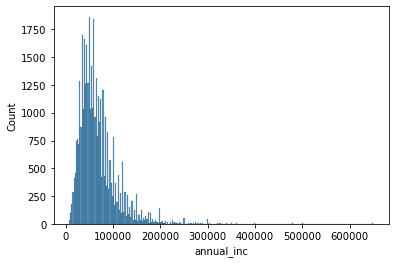

In [9]:
# sprawdzam, jak wygląda histogram jednej ze zmiennych, aby sprawdzić, czy outliers zostały usunięte - histogram poprawił się.
sns.histplot(x='annual_inc',data=df)

In [10]:
df.to_csv('Loan_data_no_outliers.csv', index=False)

### Nowe zmienne

In [11]:
df['emp_length_bin'] = (df['emp_length'] == 10).astype(int)
df["emp_length_bin"].head()

0    1
1    0
2    1
3    1
4    0
Name: emp_length_bin, dtype: int32

In [12]:
# to samo dla paru innych zmiennych:
df['annual_inc_bin'] = (df['annual_inc'] >= df['annual_inc'].median()).astype(int)
df['int_rate_bin'] = (df['int_rate'] >= df['int_rate'].median()).astype(int)
df['installmentc_bin'] = (df['installment'] >= df['installment'].median()).astype(int)
df['loan_amnt_bin'] = (df['loan_amnt'] >= df['loan_amnt'].median()).astype(int)

In [13]:
# ACC - open/total ratio
df['acc_ratio'] = df['open_acc'] / df['total_acc']

In [14]:
# logarytm - kilka zmiennych numerycznych, o skrzywionych rozkładach
column_list = ['annual_inc', 'loan_amnt', 'int_rate', 'installment']
def logarithm_transform(df, column):
    name = column+"_log+1"
    df[name] = (df[column]+1).transform(np.log)

for column in column_list:
    logarithm_transform(df,column)

In [15]:
df.to_csv('Loan_data_new_variables.csv', index=False)

### Standaryzacja zmiennych

In [16]:
df_x = df.drop('target', axis=1)
df_y = df[['target']]

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_x_array = scaler.fit_transform(df_x) # tutaj dostajemy zbior po standaryzacji w formie macierzy
df_x = pd.DataFrame(scaled_x_array,columns=df_x.columns) # a tu zamieniamy na dataframe

In [18]:
df_x.to_csv('Loan_data_no_outliers_x_stand.csv', index=False)
df_y.to_csv('Loan_data_y.csv', index=False)

<AxesSubplot:>

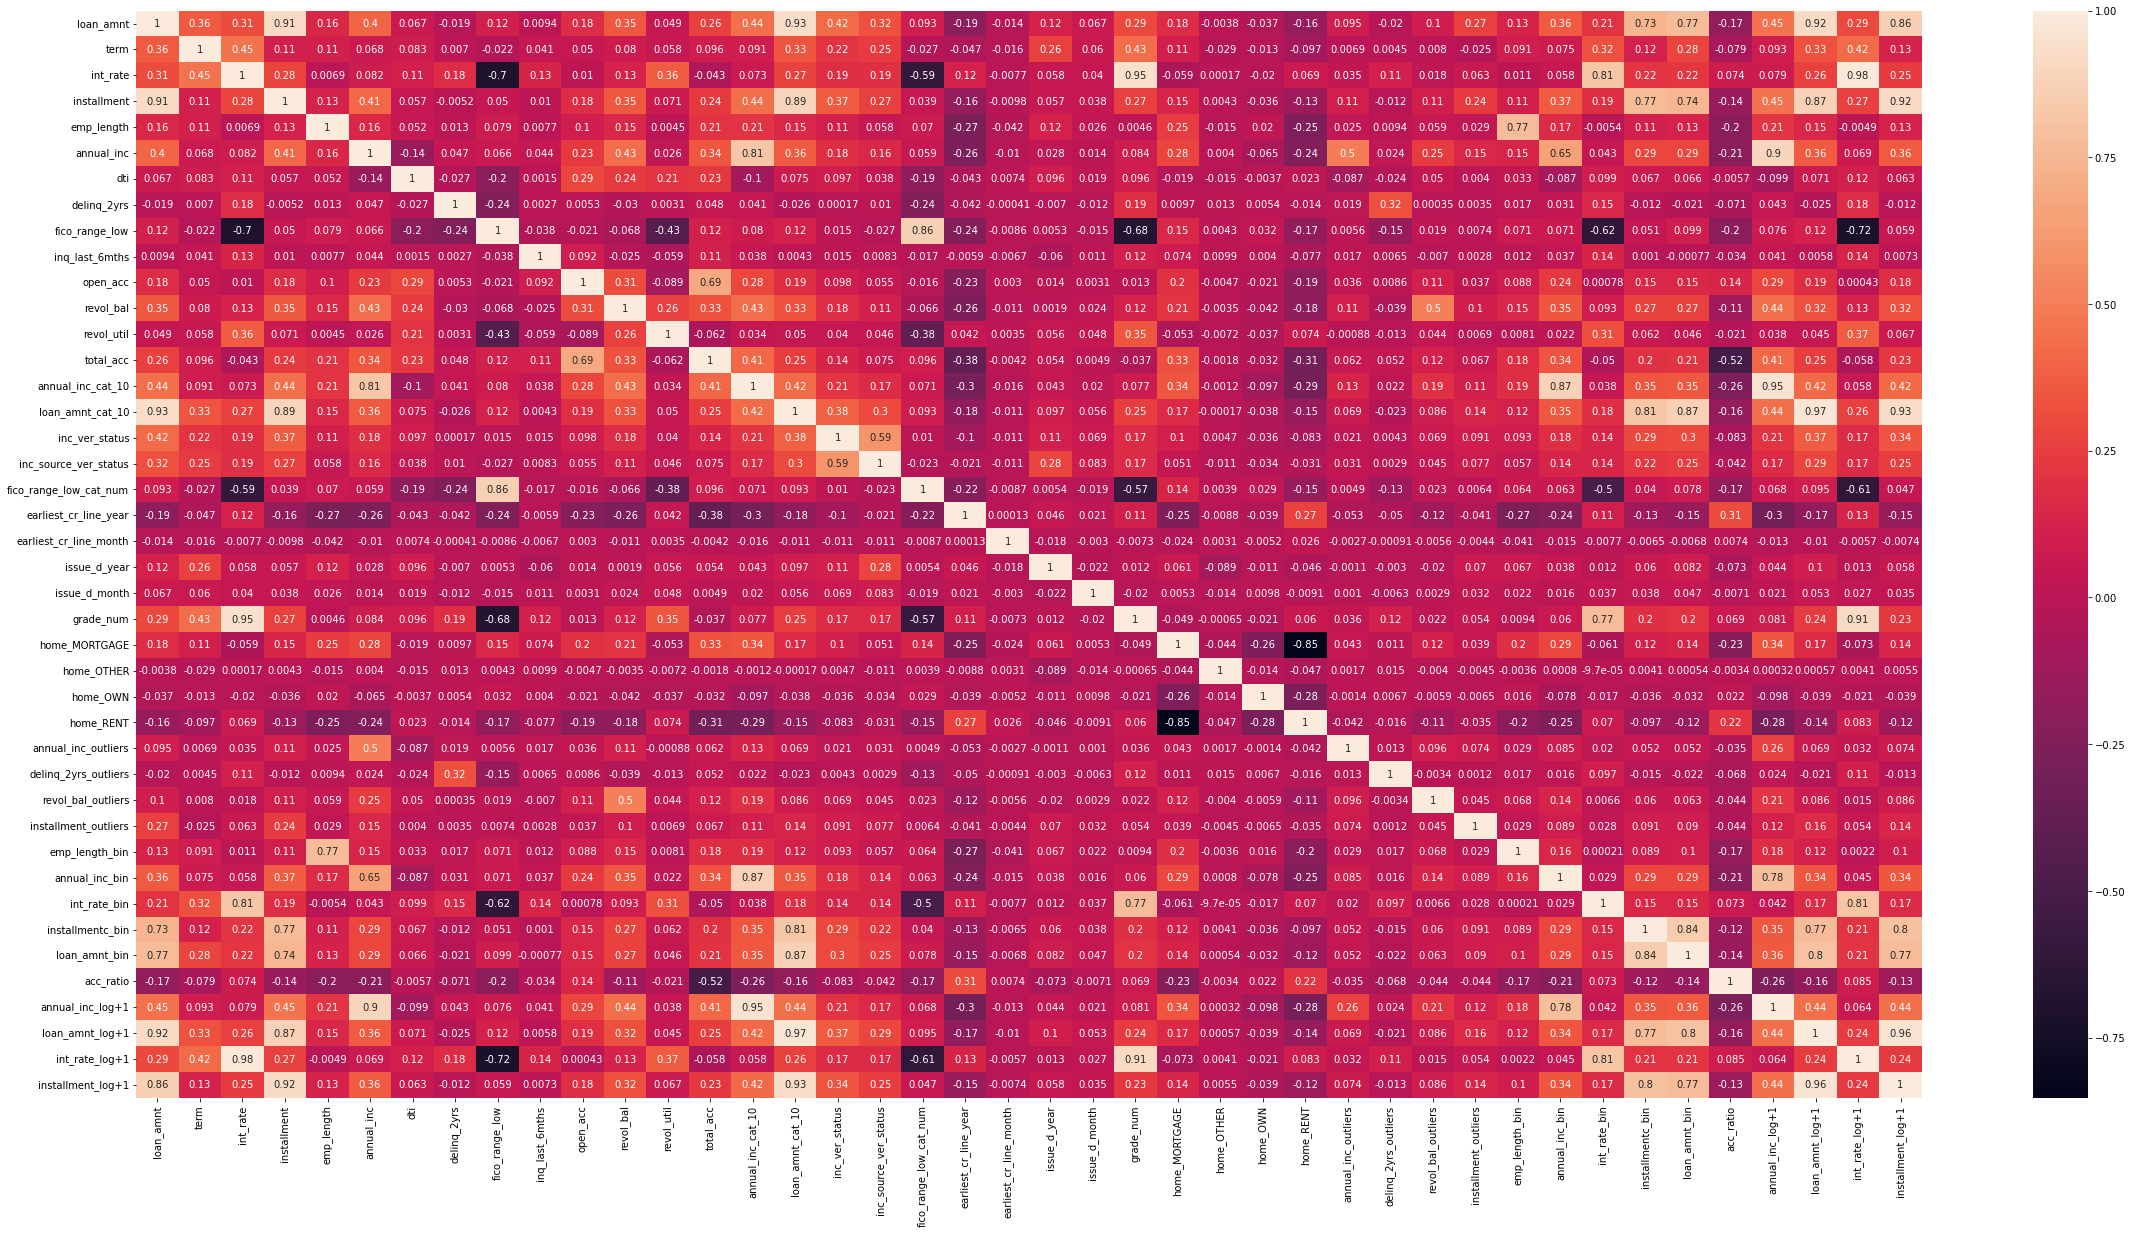

In [19]:
plt.figure(figsize = (40,20))       
sns.heatmap(df_x.corr(),annot = True)

### PCA

Ponieważ mam nadal sporo zmiennych skorelowanych ze sobą, użyję metody redukcji wymiarów - dzięki czemu mogę ze zbioru o większej liczbie zmiennych stworzyć zbiór o dużo mniejszej liczbie zmiennych, zachowując większość informacji z nich płynących.

In [20]:
df_x.shape

(39786, 42)

In [21]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_x_array)

PCA()

In [22]:
pca.explained_variance_ratio_

array([2.10821030e-01, 1.26518055e-01, 7.31717704e-02, 4.85986183e-02,
       4.06008878e-02, 3.60035090e-02, 3.43689196e-02, 3.17376860e-02,
       2.84105123e-02, 2.81566023e-02, 2.63218600e-02, 2.55879454e-02,
       2.48708195e-02, 2.46324216e-02, 2.36948873e-02, 2.35857729e-02,
       2.25303446e-02, 2.15172422e-02, 1.98149002e-02, 1.67696793e-02,
       1.55394022e-02, 1.43086789e-02, 1.23442567e-02, 9.72819040e-03,
       9.23275014e-03, 8.62618163e-03, 8.29623036e-03, 6.15720303e-03,
       5.68454338e-03, 5.35908306e-03, 3.32701484e-03, 3.22316137e-03,
       2.36611781e-03, 2.08957367e-03, 1.78182641e-03, 1.56964517e-03,
       1.36459028e-03, 5.24055035e-04, 5.12353444e-04, 1.71632183e-04,
       7.69020478e-05, 3.14486343e-06])

In [23]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.21082103, 0.33733908, 0.41051085, 0.45910947, 0.49971036,
       0.53571387, 0.57008279, 0.60182048, 0.63023099, 0.65838759,
       0.68470945, 0.7102974 , 0.73516821, 0.75980064, 0.78349552,
       0.8070813 , 0.82961164, 0.85112888, 0.87094378, 0.88771346,
       0.90325287, 0.91756154, 0.9299058 , 0.93963399, 0.94886674,
       0.95749292, 0.96578915, 0.97194636, 0.9776309 , 0.98298998,
       0.986317  , 0.98954016, 0.99190628, 0.99399585, 0.99577768,
       0.99734732, 0.99871191, 0.99923597, 0.99974832, 0.99991995,
       0.99999686, 1.        ])

Komentarz: skumulowana wyjaśniana wariancja nie rośnie wcale tak szybko - to znaczy, że mimo wysokiej korelacji liniowej między wieloma zmiennymi niosą one ze sobą wiele indywidualnych informacji. 95% wariancji osiągam dopiero przy 26 zmiennych po PCA, podczas gdy do redukcji wrzuciłam 42 zmienne.

In [24]:
from sklearn.decomposition import IncrementalPCA

pca_final = IncrementalPCA(n_components=26)
array_x_pca = pca_final.fit_transform(scaled_x_array)

In [25]:
df_x = pd.DataFrame(array_x_pca)

In [26]:
df_x.to_csv('Loan_data_no_outliers_x_stand_PCA.csv', index=False)

<AxesSubplot:>

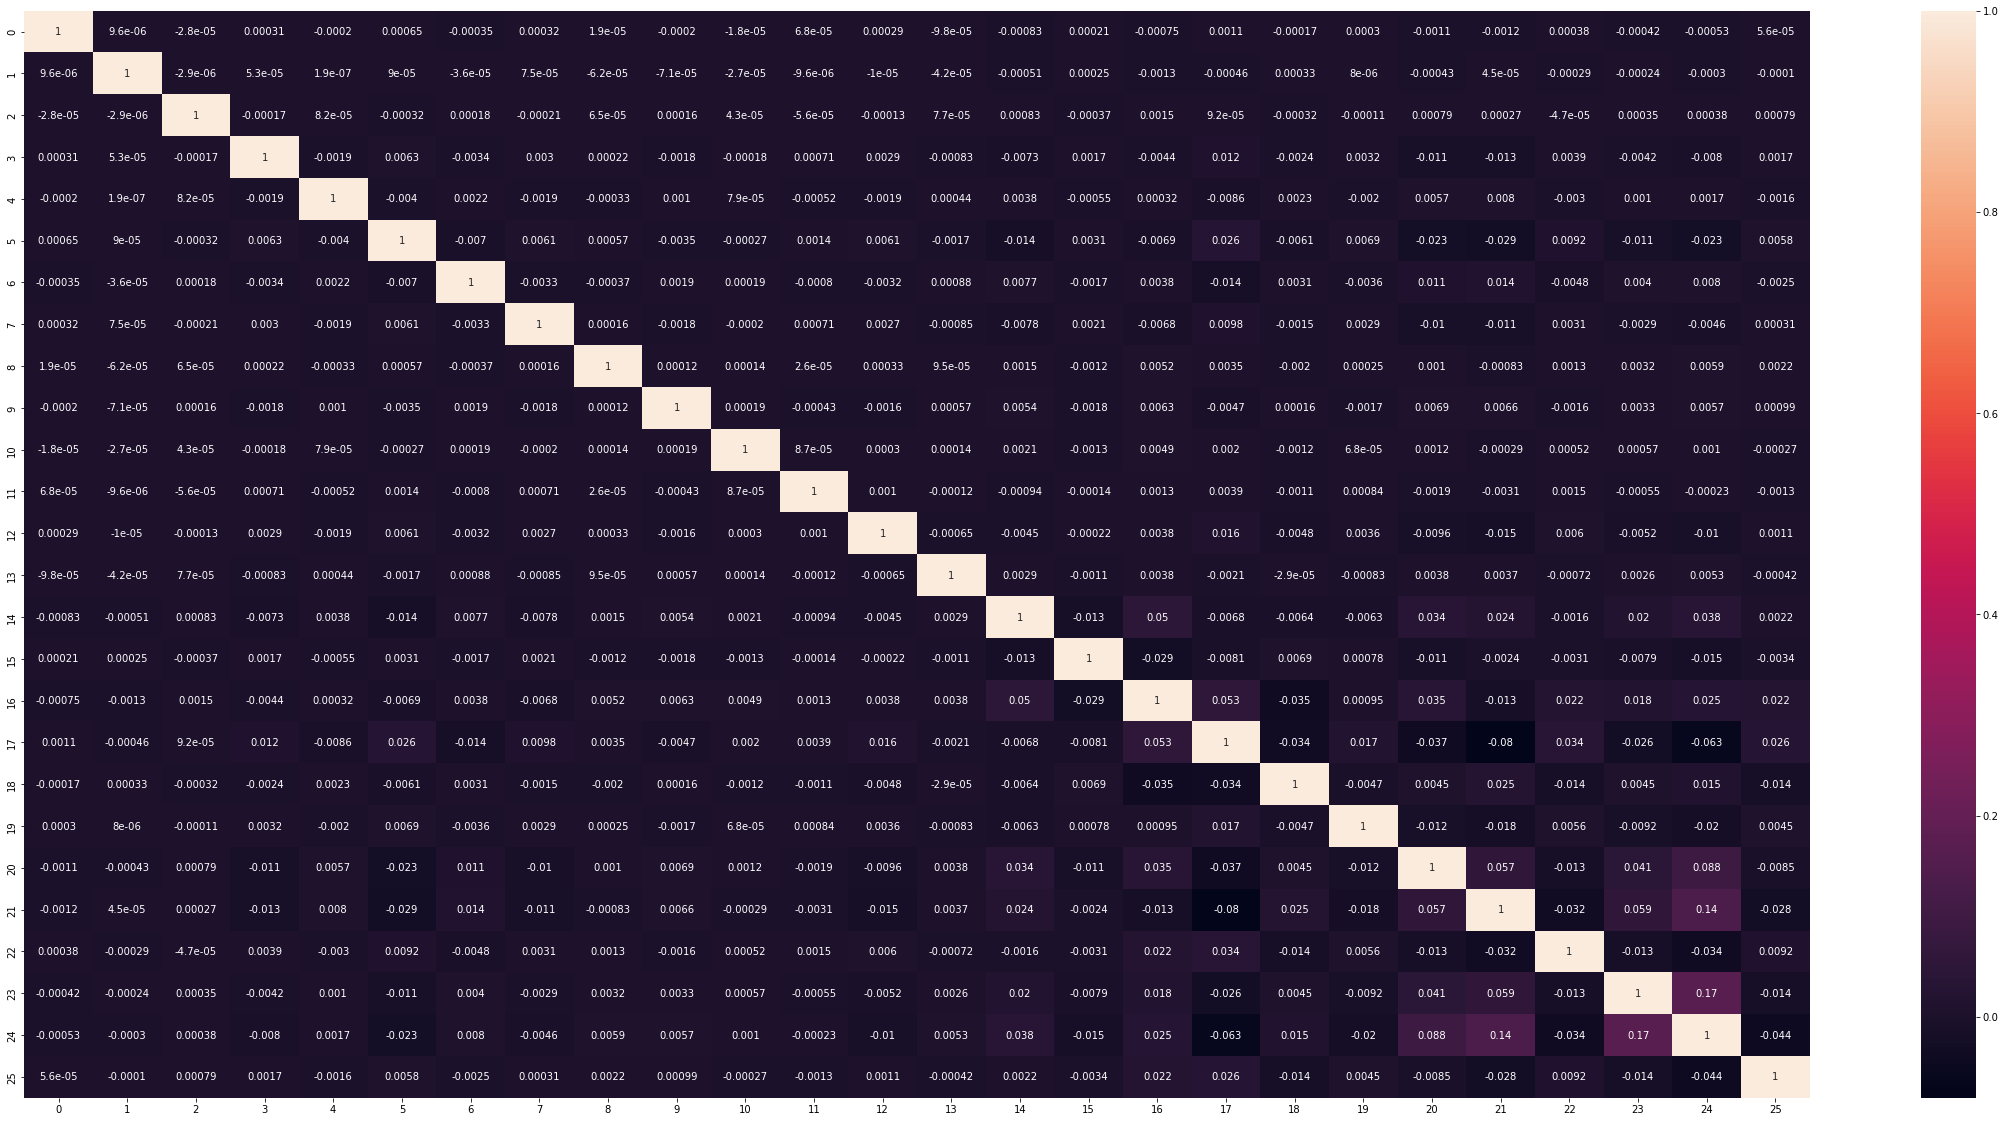

In [27]:
plt.figure(figsize = (40,20))       
sns.heatmap(df_x.corr(),annot = True)

Tak jak bym oczekiwała, zmienne po PCA nie są ze sobą skorelowane. Wyższa korelacja pojawia się z ostatnim komponentach, która wnoszą już bardzo znikomą ilość informacji.